In [1]:
from __future__ import print_function, division
import thinkbayes
#import thinkplot

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, halfnorm, triang, gamma, gumbel_r, gumbel_l, lognorm 
import scipy.interpolate as interpolate

from math import sqrt, pi

In [2]:
class Invest(thinkbayes.Suite):
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        hypo: integer value of x, the probability of heads (0-100)
        data: string 'H' or 'T'
        """
        p = hypo / 100.0
        if data == 'H':
            return p
        else:
            return 1-p


############################################# PLOTTING FUNCTIONS
def plot_aggregator(data_h, data_w, gamma, sigma):
    # evenly sampled time at 1 intervals
    t = np.arange(1, data_h.shape[0]+1, 1)
    plt.plot(t,data_h.mean(1), 'r', linewidth=5.0, label='Herding')     
    plt.plot(t,data_w.mean(1), 'b', linewidth=5.0, label='Wisdom')  # row axis is 1; column axis is 0. http://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.mean.html#numpy.matrix.mean
    theta_down= gamma-sigma
    theta_up= gamma+sigma
    plt.axhline(y=theta_down)
    plt.axhline(y=theta_up)
    plt.ylabel('The evolution of beliefts')
    plt.ylim((0,100))
    plt.legend()
    plt.show()

def plotme_one_graph_w_confidence_interval(data_h, data_w, theta_down, theta_up):
    # evenly sampled time at 1 intervals
    t = np.arange(1, data_h.shape[0]+1, 1)
    plt.plot(t,data_h[:,0], 'r--')
    plt.plot(t,data_h[:,1], 'r--') 
    herding_, =plt.plot(t,data_h[:,2], 'r', linewidth=5.0, label='Herding')     
    plt.plot(t,data_w[:,0], 'b--')
    plt.plot(t,data_w[:,1], 'b--') 
    wisdom_ = plt.plot(t,data_w[:,2], 'b', linewidth=5.0, label='Wisdom')
    plt.axhline(y=theta_down)
    plt.axhline(y=theta_up)
    plt.ylabel('The evolution of beliefts')
    plt.ylim((0,100))
    plt.legend()
    plt.show()


########################
def AverageLikelihood(suite, data):
    total = 0
    for hypo, prob in suite.Items():
        like = suite.Likelihood(data, hypo)
        total += prob * like
    return total


def analyze(suite, evidence, theta_down=50, theta_up=75,herding='herding'):
    list_=[]
    actual=[]
    if herding=='herding':
        for outcome in evidence:
            #theta_start = AverageLikelihood(suite, outcome)
            theta_start = suite.MaximumLikelihood()
            ci= suite.CredibleInterval(90)
            list_.append([ci[0],ci[1], theta_start])
            if theta_start>theta_down and theta_start<theta_up:
                suite.Update(outcome)
                actual.append(outcome)
                #print("mid")
            elif theta_start>=theta_up:
                suite.Update('H')
                actual.append('H')
                #print("H")
            elif theta_start<=theta_down:
                suite.Update('T')
                actual.append('T')
                #print("T")
    elif herding=='wisdom':
        for outcome in evidence:
            theta_start = suite.MaximumLikelihood()
            ci= suite.CredibleInterval(90)
            list_.append([ci[0],ci[1], theta_start])
            suite.Update(outcome)
            actual.append(outcome)
    return list_, suite, actual


################################
'''
def triangle_prior(mode):
    suite = Invest()
    for x in range(0, mode+1):
        suite.Set(x, x)
    for x in range(mode+1, 101):
        suite.Set(x, mode/(100-mode)*(100-x))
    suite.Normalize()
    return suite
'''
def triangle_pior(mode):
    suite = Invest()
    for x in range(0,101):
        suite.Set(x, triang.pdf(x,c=mode/100.0, loc=0, scale=100))
    suite.Normalize()
    return suite


def normal_prior(mean, sd):
    suite = Invest()
    for x in range(0,101):
        suite.Set(x, norm.pdf(x, loc=mean, scale=sd))
    suite.Normalize()
    return suite

def ushaped_prior(mean_left, sd_left, mean_right, sd_right):
    suite = Invest()
    left_side= halfnorm.rvs(loc=mean_left, scale=sd_left, size=1000)
    ##
    right_side = halfnorm.rvs(loc=mean_right, scale=sd_right, size=1000)
    a = np.empty(right_side.size)
    a.fill(100.0)
    shift_right=-1*right_side + a
    data= np.hstack((left_side,shift_right, np.linspace(0, 100.0, num=1000)))
    hist, bin_edges = np.histogram(data, bins = np.arange(102), density=True)
    for x in range(0,101):
        suite.Set(x, hist[x])
    suite.Normalize()
    return suite

def gamma_pior(shape, scale):
    suite = Invest()
    for x in range(0,101):
        suite.Set(x, gamma.pdf(x, shape, loc=0, scale=scale))
    suite.Normalize()
    return suite

def gumbel_r_pior(loc, scale):
    suite = Invest()
    for x in range(0,101):
        suite.Set(x, gumbel_r.pdf(x, loc=loc, scale=scale))
    suite.Normalize()
    return suite

def gumbel_l_pior(loc, scale):
    suite = Invest()
    for x in range(0,101):
        suite.Set(x, gumbel_l.pdf(x, loc=loc, scale=scale))
    suite.Normalize()
    return suite

def lognorm_prior(mean, sd):
    suite = Invest()
    for x in range(0,101):
        suite.Set(x, lognorm.pdf(x, loc=mean, scale=sd))
    suite.Normalize()
    return suite




###################################
def evidence_fun(random_numbers, threshold_quality=75 ):
    evidence=''
    for item in random_numbers:
        if item>=threshold_quality: 
            evidence +='H'
        else:
            evidence +='T'
    return evidence    

###################################
def gen_evidence_normal(mean, sd, size=100, threshold_quality=75):
    r = norm.rvs(loc=mean, scale=sd, size=size)
    return evidence_fun(r, threshold_quality = threshold_quality)

def gen_evidence_ushaped(mean_left, sd_left, mean_right, sd_right, size=100, threshold_quality=75):
    left_side= halfnorm.rvs(loc=mean_left, scale=sd_left, size=size)
    ##
    right_side = halfnorm.rvs(loc=mean_right, scale=sd_right, size=size)
    a = np.empty(right_side.size)
    a.fill(100.0)
    shift_right=-1*right_side + a
    data= np.hstack((left_side,shift_right, np.linspace(0, 100.0, num=size)))
    r= inverse_transform_sampling(data,n_bins=100, n_samples=size  ) #project quality varies from 0 to 100.
    return evidence_fun(r, threshold_quality = threshold_quality)

def gen_evidence_triangle(mode, size=100, threshold_quality=75):
    r= triang.rvs(c = mode/100.0, loc=0, scale  =100, size=size) #project quality varies from 0 to 100.
    return evidence_fun(r, threshold_quality = threshold_quality)


def gen_evidence_gamma(shape, scale, size=100, threshold_quality=75):
    r = gamma.rvs(shape, loc=0, scale=scale, size=size)
    return evidence_fun(r, threshold_quality = threshold_quality)

def gen_evidence_gumbel_r(loc, scale, size=100, threshold_quality=75):
    r = gumbel_r.rvs(loc=loc, scale=scale, size=size)
    return evidence_fun(r, threshold_quality = threshold_quality)

def gen_evidence_gumbel_l(loc, scale, size=100, threshold_quality=75):
    r = gumbel_l.rvs(loc=loc, scale=scale, size=size)
    return evidence_fun(r, threshold_quality = threshold_quality)

def gen_evidence_lognorm(mean, sd, size=100, threshold_quality=75):
    r = lognorm.rvs(shape = sd, loc=mean, scale=sd, size=size)
    return evidence_fun(r, threshold_quality = threshold_quality)



###################################
#http://www.nehalemlabs.net/prototype/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/   
def inverse_transform_sampling(data, n_bins=40, n_samples=1000):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)



In [3]:
def result(method, steps=100, threshold_quality=75, gamma=50, sigma=25):
    # which case is the method
    if method['private_belief_distribution'] == 'normal':
        mean = method['mean']
        sd = method['sd']
        suite_h = normal_prior(mean=mean, sd=sd)
        suite_w = normal_prior(mean=mean, sd=sd)
        #suite_prior = normal_prior(mean=mean, sd=sd)
        evidence = gen_evidence_normal(mean=mean, sd=sd, size=steps, threshold_quality=threshold_quality)
    elif method['private_belief_distribution'] == 'ushaped':
        mean_left = method['mean_left']
        sd_left= method['sd_left']
        mean_right = method['mean_right']
        sd_right= method['sd_right']
        if method['initial_prior']=='normal':
            suite_h = normal_prior(mean=50, sd=(sd_left+sd_right)/2)
            suite_w = normal_prior(mean=50, sd=(sd_left+sd_right)/2)           
        else:
            suite_h = ushaped_prior(mean_left, sd_left, mean_right, sd_right)
            suite_w = ushaped_prior(mean_left, sd_left, mean_right, sd_right)
        evidence = gen_evidence_ushaped(mean_left, sd_left, mean_right, sd_right ,size=steps,threshold_quality= threshold_quality)
    elif method['private_belief_distribution'] == 'triangle':
        mode= method['mode']
        suite_h = triangle_pior(mode = mode)
        suite_w = triangle_pior(mode = mode)
        evidence = gen_evidence_triangle(mode = mode , size= steps, threshold_quality= threshold_quality)
    elif method['private_belief_distribution'] == 'gamma':
        if 'shape' in method:
            shape = method['shape']
            scale = method['scale']
        elif 'mean' in method:
            shape = (method['mean']*method['mean'])/(method['sd']*method['sd'])
            scale = (method['sd']*method['sd']) / method['mean']
        if 'initial_prior' in method:
            if method['initial_prior']=='normal':
                mean= method['mean']
                sd= method['sd']
                # of initial prior is set to normal then input should also be only mean and SD.
                suite_h = normal_prior(mean=mean, sd=sd)
                suite_w = normal_prior(mean=mean, sd=sd)
            else:
                suite_h = gamma_pior(shape=shape, scale= scale)
                suite_w = gamma_pior(shape=shape, scale= scale)
        evidence = gen_evidence_gamma(shape=shape, scale= scale, size=steps, threshold_quality=threshold_quality)
    elif method['private_belief_distribution'] == 'gumbel_r':
        if 'initial_prior' in method:
            if method['initial_prior']=='normal':
                mean= method['mean']
                sd= method['sd']
                # of initial prior is set to normal then input should also be only mean and SD.
                suite_h = normal_prior(mean=mean, sd=sd)
                suite_w = normal_prior(mean=mean, sd=sd)
            else:
                #https://en.wikipedia.org/wiki/Gumbel_distribution
                mean = method['mean']
                sd = method['sd']
                scale= sd* 6**.5 / pi
                loc= mean- scale * 0.57721  # Euler's constant: https://en.wikipedia.org/wiki/Euler–Mascheroni_constant
                suite_h = gumbel_r_pior(loc=loc, scale=scale)
                suite_w = gumbel_r_pior(loc=loc, scale=scale)
        evidence = gen_evidence_gumbel_r(loc=loc, scale=scale, size=steps, threshold_quality=threshold_quality)
    elif method['private_belief_distribution'] == 'gumbel_l':
        if 'initial_prior' in method:
            if method['initial_prior']=='normal':
                mean= method['mean']
                sd= method['sd']
                # of initial prior is set to normal then input should also be only mean and SD.
                suite_h = normal_prior(mean=mean, sd=sd)
                suite_w = normal_prior(mean=mean, sd=sd)
            else:
                #https://en.wikipedia.org/wiki/Gumbel_distribution
                mean = method['mean']
                sd = method['sd']
                scale= sd* 6**.5 / pi
                loc= mean+ scale * 0.57721  # Euler's constant: https://en.wikipedia.org/wiki/Euler–Mascheroni_constant
                suite_h = gumbel_l_pior(loc=loc, scale=scale)
                suite_w = gumbel_l_pior(loc=loc, scale=scale)
        evidence = gen_evidence_gumbel_l(loc=loc, scale=scale, size=steps, threshold_quality=threshold_quality)
    elif method['private_belief_distribution'] == 'lognormal':
        #If log(x) is normally distributed with mean mu and variance sigma**2, then x is log-normally distributed with shape parameter sigma and scale parameter exp(mu).
        mean = method['mean']
        sd = method['sd']
        suite_h = lognorm_prior(mean=mean, sd=sd)
        suite_w = lognorm_prior(mean=mean, sd=sd)
        evidence = gen_evidence_lognorm(mean=mean, sd=sd, size=steps, threshold_quality=threshold_quality)
    else:
        suite_h = Invest(range(0, 101))
        suite_w = Invest(range(0, 101))
        evidence = gen_evidence_uniform(size=steps,threshold_quality= threshold_quality)      
    theta_down= gamma-sigma
    theta_up= gamma+sigma
    list_info_h, suite_h, actual_h= analyze(suite_h, evidence, theta_down= theta_down, theta_up= theta_up,  herding='herding')
    list_info_w, suite_w, actual_w= analyze(suite_w, evidence,  herding='wisdom')
    # plotme_one_graph_w_confidence_interval(np.matrix(list_info_h) , np.matrix(list_info_w), theta_down, theta_up )
    return np.matrix(list_info_h), np.matrix(list_info_w)
    

def replicate_results(method, steps=100, threshold_quality=75, gamma=50, sigma=25, repeat=100):
    aggregator_h = np.matrix(np.zeros(shape=(steps,repeat)))
    aggregator_w = np.matrix(np.zeros(shape=(steps,repeat)))
    for t in range(repeat):
        data_h, data_w=result(method= method, steps=steps, threshold_quality=threshold_quality, gamma=gamma, sigma=sigma )
        aggregator_h[:,t]= data_h[:,2]
        aggregator_w[:,t]= data_w[:,2]
    return plot_aggregator(aggregator_h, aggregator_w, gamma, sigma)


In [6]:
# (gamma - sigma, gamma + sigma) is the complement of cascade set.
def get_inputs(MEAN_input, SD_input ):
    replicate_results(method={'private_belief_distribution': 'normal', 'mean': MEAN_input , 'sd': SD_input}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
    replicate_results(method={'private_belief_distribution': 'gumbel_r', 'mean': MEAN_input, 'sd': SD_input, 'initial_prior':'itself'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)
    replicate_results(method={'private_belief_distribution': 'gumbel_l', 'mean': MEAN_input, 'sd': SD_input, 'initial_prior':'itself'}, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)





<h1 align="center">RESULTS</h1> 
<h3 align="center"> first graph is normal distribution. </h3> 
<h3 align="center"> second graph is gumbel right distribution. </h3> 
<h3 align="center"> third graph is gumbel left distribution.</h3> 

#### In all the following I only change the mean, all other parameters are fixed and set at (steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)

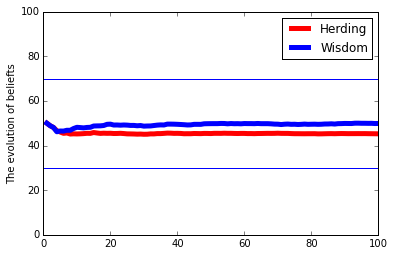

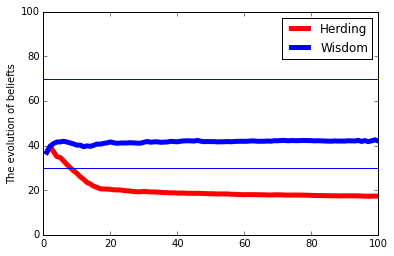

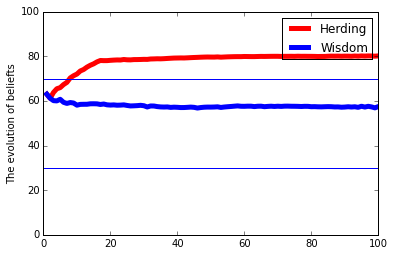

In [10]:
get_inputs(MEAN_input= 50,SD_input= 30)

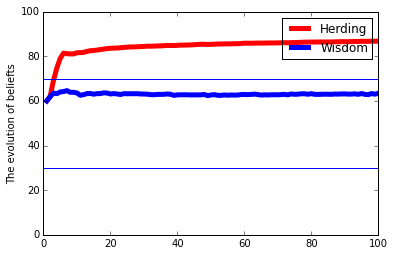

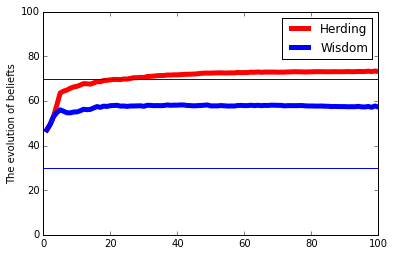

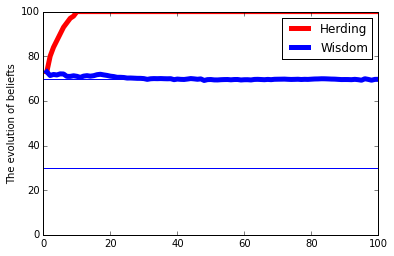

In [8]:
get_inputs(MEAN_input= 60,SD_input= 30)

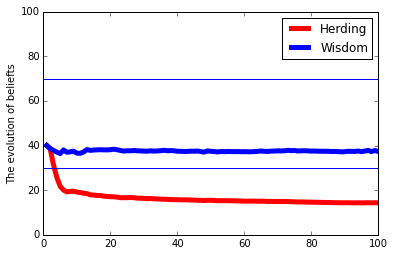

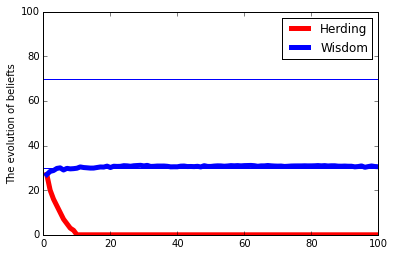

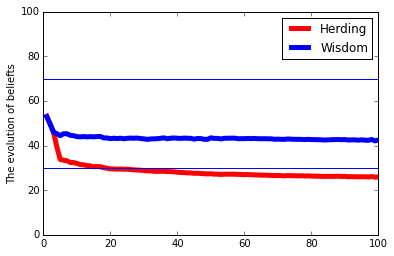

In [9]:
get_inputs(MEAN_input= 40,SD_input= 30)